# ResNet lekin boshqasini ham training qilish mumkin
resnetni natijasi bor

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import time


from PIL import Image
import matplotlib.pyplot as plt

# CUDA ni tekshirish

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
    print(f"GPU mavjud: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")  # CPU
    print("GPU mavjud emas, CPU ishlatiladi.")
    
torch.cuda.empty_cache()   # Xotiradan bo‘shatish

GPU mavjud: NVIDIA GeForce RTX 3060


# Transformatsiyalar

In [3]:
# Transformatsiyalar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Ma'lumotlar to'plamini yuklash
train_dataset = datasets.ImageFolder(root='fer_2013_new/train', transform=transform)
val_dataset = datasets.ImageFolder(root='fer_2013_new/test', transform=transform_val)

# DataLoader yaratish
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Modelni tanlash va moslashtirish

In [4]:
def get_model(model_name, num_classes=7):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Noto'g'ri model nomi!")
    return model

Train va Validation funksiyalari

In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

Asosiy train loop

In [6]:
res_val_loss = []
res_val_acc = []
res_train_acc = []
res_train_loss = []

def main(model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    num_epochs = 15
    best_val_acc = 0.0  # Eng yaxshi validation accuracy ni saqlash uchun

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        epoch_time = time.time() - start_time

        # Har bir epoch natijalarini chiqarish
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%, "
              f"Time: {epoch_time:.2f}s")
        res_val_acc.append(val_acc)
        res_val_loss.append(val_loss)
        res_train_acc.append(train_acc)
        res_train_loss.append(train_loss)
        # Har bir epochda modelni saqlash
        torch.save(model.state_dict(), f'{model_name}_model_epoch_{epoch+1}.pth')
        print(f"Model saved as model_epoch_{epoch+1}.pth")

        # Eng yaxshi modelni saqlash
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"New best model saved with Val Accuracy: {best_val_acc:.2f}%")


# REsNET-50 yangisi

In [7]:
model_name = 'resnet'  # 'resnet', 'vgg', yoki 'efficientnet' tanlang
main(model_name)

c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.2199, Train Accuracy: 54.67%, Val Loss: 0.9712, Val Accuracy: 63.62%, Time: 877.36s
Model saved as model_epoch_1.pth
New best model saved with Val Accuracy: 63.62%
Epoch 2/15, Train Loss: 0.9462, Train Accuracy: 65.29%, Val Loss: 0.8715, Val Accuracy: 67.40%, Time: 453.49s
Model saved as model_epoch_2.pth
New best model saved with Val Accuracy: 67.40%
Epoch 3/15, Train Loss: 0.8629, Train Accuracy: 68.13%, Val Loss: 0.8364, Val Accuracy: 69.04%, Time: 336.35s
Model saved as model_epoch_3.pth
New best model saved with Val Accuracy: 69.04%
Epoch 4/15, Train Loss: 0.8016, Train Accuracy: 70.48%, Val Loss: 0.8015, Val Accuracy: 70.33%, Time: 353.83s
Model saved as model_epoch_4.pth
New best model saved with Val Accuracy: 70.33%
Epoch 5/15, Train Loss: 0.7508, Train Accuracy: 72.43%, Val Loss: 0.7982, Val Accuracy: 70.57%, Time: 301.02s
Model saved as model_epoch_5.pth
New best model saved with Val Accuracy: 70.57%
Epoch 6/15, Train Loss: 0.7045, Train Accuracy: 74

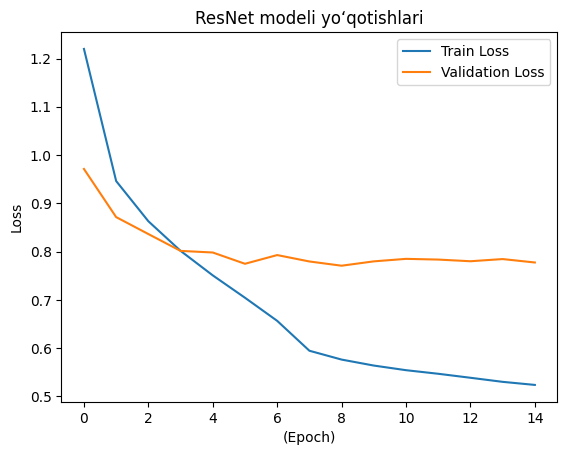

In [8]:
plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli yo‘qotishlari')
plt.show()

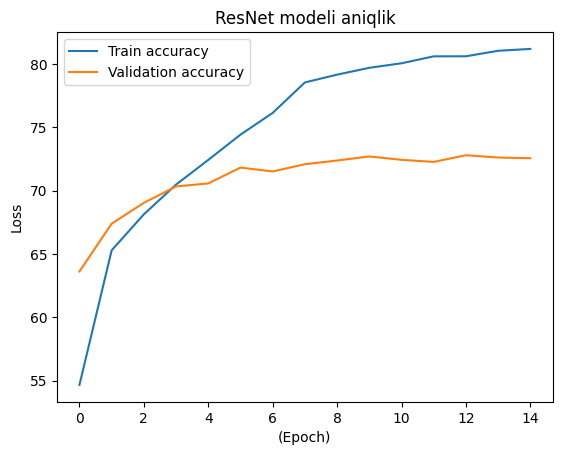

In [9]:
plt.plot(res_train_acc, label='Train accuracy')
plt.plot(res_val_acc, label='Validation accuracy')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli aniqlik')
plt.show()

Asosiy ishga tushirish

# RESNET da

Yangi resnet

In [53]:
model_name = 'resnet'  # 'resnet', 'vgg', yoki 'efficientnet' tanlang
main(model_name)

c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.1388, Train Accuracy: 57.33%, Val Loss: 1.0981, Val Accuracy: 58.97%, Time: 587.07s
Model saved as model_epoch_1.pth
New best model saved with Val Accuracy: 58.97%
Epoch 2/15, Train Loss: 0.9799, Train Accuracy: 63.39%, Val Loss: 0.9703, Val Accuracy: 63.82%, Time: 131.96s
Model saved as model_epoch_2.pth
New best model saved with Val Accuracy: 63.82%
Epoch 3/15, Train Loss: 0.9145, Train Accuracy: 65.69%, Val Loss: 0.9085, Val Accuracy: 65.52%, Time: 153.81s
Model saved as model_epoch_3.pth
New best model saved with Val Accuracy: 65.52%
Epoch 4/15, Train Loss: 0.8797, Train Accuracy: 67.12%, Val Loss: 0.9482, Val Accuracy: 65.10%, Time: 187.59s
Model saved as model_epoch_4.pth
Epoch 5/15, Train Loss: 0.8368, Train Accuracy: 68.72%, Val Loss: 0.9243, Val Accuracy: 65.88%, Time: 184.93s
Model saved as model_epoch_5.pth
New best model saved with Val Accuracy: 65.88%
Epoch 6/15, Train Loss: 0.8055, Train Accuracy: 69.76%, Val Loss: 0.8620, Val Accuracy: 68.30%, T

In [54]:
print(res_val_acc)
print(res_val_loss)
print(res_train_acc)
print(res_train_loss)

[58.97257413337046, 63.817346512599194, 65.51580119727133, 65.09814840595851, 65.87776694974245, 68.30015313935681, 67.46484755673117, 71.83628010580537, 72.54628985103717, 71.98941946262008, 72.4070722539329, 72.12863705972435, 72.36530697480161, 71.68314074899067, 72.14255881943478]
[1.0980997731233328, 0.9702565809083378, 0.908484571525255, 0.9481767377758448, 0.9242609217965853, 0.862025073849219, 0.9035438070510539, 0.7608806606868848, 0.7465217059019843, 0.7579578420028051, 0.7652983330657002, 0.7865908775952891, 0.7741186671426202, 0.7826565636552222, 0.7853397113693192]
[57.332915404172326, 63.385922752760074, 65.68801588130812, 67.1229060007662, 68.72496778462717, 69.75934245812002, 70.85292376275555, 75.2133180092641, 76.7387594469404, 77.61641068505556, 78.40002786194407, 79.29509281510117, 79.807056037335, 80.77525859366837, 81.92804652944659]
[1.138792066903316, 0.9799016068932208, 0.9145219538418912, 0.8796768396893695, 0.8367696387863371, 0.8055423628248457, 0.7825632484

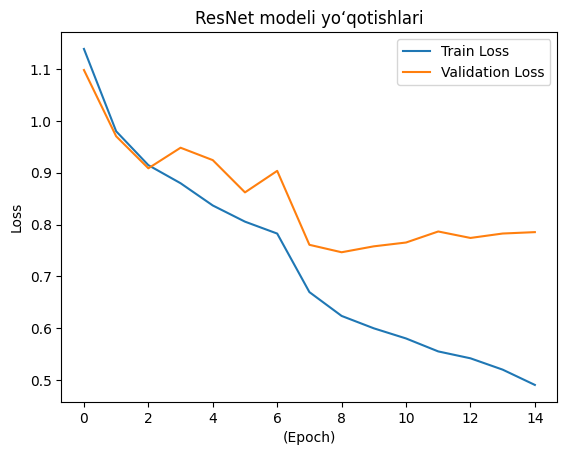

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli yo‘qotishlari')
plt.show()

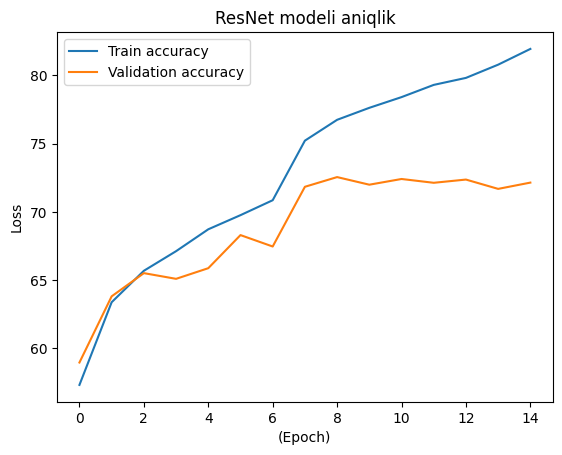

In [56]:
plt.plot(res_train_acc, label='Train accuracy')
plt.plot(res_val_acc, label='Validation accuracy')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli aniqlik')
plt.show()

# ----------------------------- EFFICIENNET ----------------------------

In [8]:
model_name = 'efficientnet'  # 'resnet', 'vgg', yoki 'efficientnet' tanlang
main(model_name)

c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.0634, Train Accuracy: 60.54%, Val Loss: 0.9061, Val Accuracy: 64.96%, Time: 781.12s
Model saved as model_epoch_1.pth
New best model saved with Val Accuracy: 64.96%
Epoch 2/15, Train Loss: 0.8762, Train Accuracy: 67.55%, Val Loss: 0.8781, Val Accuracy: 66.96%, Time: 356.00s
Model saved as model_epoch_2.pth
New best model saved with Val Accuracy: 66.96%
Epoch 3/15, Train Loss: 0.8194, Train Accuracy: 69.29%, Val Loss: 0.8280, Val Accuracy: 68.97%, Time: 355.18s
Model saved as model_epoch_3.pth
New best model saved with Val Accuracy: 68.97%
Epoch 4/15, Train Loss: 0.7614, Train Accuracy: 71.64%, Val Loss: 0.8333, Val Accuracy: 67.95%, Time: 356.36s
Model saved as model_epoch_4.pth
Epoch 5/15, Train Loss: 0.7210, Train Accuracy: 73.33%, Val Loss: 0.7852, Val Accuracy: 71.10%, Time: 355.00s
Model saved as model_epoch_5.pth
New best model saved with Val Accuracy: 71.10%
Epoch 6/15, Train Loss: 0.6857, Train Accuracy: 74.59%, Val Loss: 0.7804, Val Accuracy: 71.04%, T

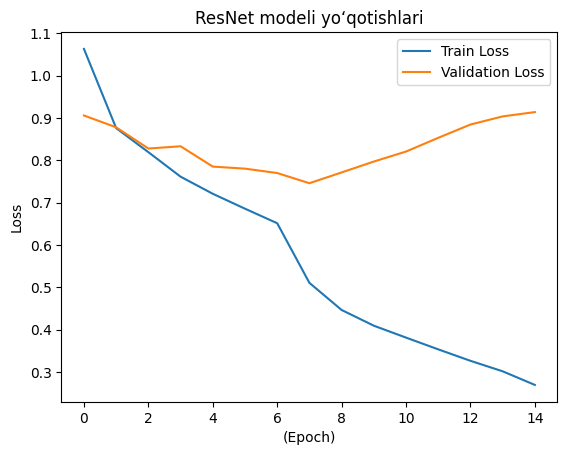

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli yo‘qotishlari')
plt.show()

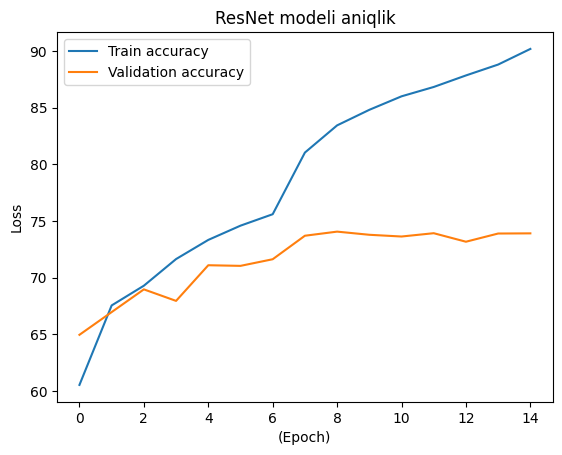

In [43]:
plt.plot(res_train_acc, label='Train accuracy')
plt.plot(res_val_acc, label='Validation accuracy')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet modeli aniqlik')
plt.show()

# efficientnet diagramma

In [ ]:
res_train_acc = [60.53703897189426, 67.55128339079859, 69.2926548949953, 71.64350642566085, 73.33263678473165, 74.58990701076168, 75.59990248319576, 81.03994706230627, 83.43955699508933, 84.81175774039633, 86.00285584926688, 86.82826594225612, 87.84522690070699, 88.80646397102358, 90.18563020234737]
res_train_loss = [1.0634223449734643, 0.8761697760669054, 0.8193968731603006, 0.7614304647679319, 0.7209873466953668, 0.6857309163545978, 0.6513894197006268, 0.5104078399577491, 0.4463281213639839, 0.4091366180996587, 0.3809984787004297, 0.3532249584362608, 0.32612094724496915, 0.30132950011035115, 0.2691466035715456]
res_val_acc = [64.95893080885423, 66.96366420715579, 68.96839760545733, 67.95210914659613, 71.09842684115272, 71.04273980231102, 71.62745371014897, 73.70179590700265, 74.06376165947376, 73.78532646526521, 73.63218710845051, 73.92454406236948, 73.17276903800641, 73.89670054294862, 73.91062230265905]
res_val_loss = [0.9061202532405742, 0.8780874881056236, 0.8279508464972013, 0.8332982125679964, 0.7852340939369532, 0.7804083788715189, 0.7700408243616572, 0.7459417214354802, 0.771425746354126, 0.7971616620062589, 0.8208344679232518, 0.853248290299033, 0.884693873846021, 0.9039057684782613, 0.91409068673449]

print(res_train_acc)
print(res_train_loss)
print(res_val_acc)
print(res_val_loss)

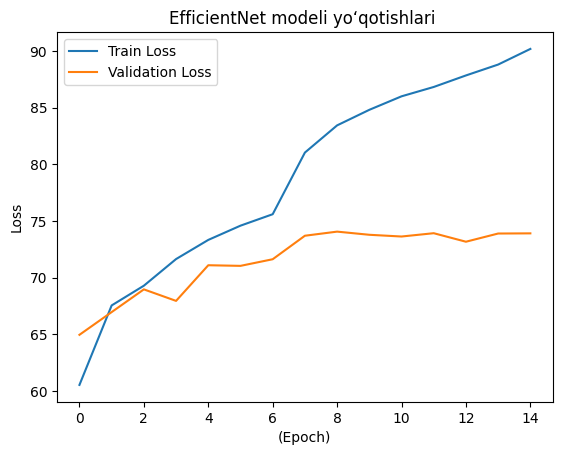

In [39]:
plt.plot(res_train_acc, label='Train Loss')
plt.plot(res_val_acc, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('EfficientNet modeli yo‘qotishlari ')
plt.show()

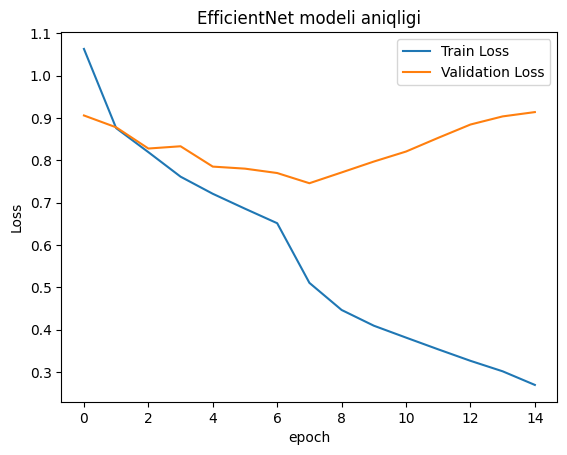

In [40]:
plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('EfficientNet modeli aniqligi')
plt.show()